In [37]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
items = pd.read_csv('competitive-data-science-predict-future-sales/items.csv')
shops = pd.read_csv('competitive-data-science-predict-future-sales/shops.csv')
cats = pd.read_csv('competitive-data-science-predict-future-sales/item_categories.csv')
sales = pd.read_csv('competitive-data-science-predict-future-sales/sales_train.csv')
# set index to ID to avoid droping it later
test  = pd.read_csv('competitive-data-science-predict-future-sales/test.csv').set_index('ID')

In [3]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [4]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [5]:
cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [6]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [7]:
test.head()

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


## Do Basic EDA and remove outliers

In [8]:
sales = sales[sales['item_price']<100000]
sales = sales[sales['item_cnt_day']<=1000]

## Group data at a level you want your predictions to be:

In [9]:
from itertools import product
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = []
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

In [10]:
grid.sample(5)

,shop_id,item_id,date_block_num
7871496,49,15705,22
7217871,42,14649,20
9840739,48,10966,29
2137988,19,10109,5
4186486,7,14337,11


In [11]:
sales_m = sales.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': 'sum','item_price': np.mean}).reset_index()

# merging with grid dataFrame
sales_m = pd.merge(grid,sales_m,on=['date_block_num','shop_id','item_id'],how='left').fillna(0)

# adding the category id too
sales_m = pd.merge(sales_m,items,on=['item_id'],how='left')

In [12]:
sales_m.sample(5)

,shop_id,item_id,date_block_num,item_cnt_day,item_price,item_name,item_category_id
8931345,22,3082,25,0.0,0.0,EAGLES The Complete Greatest Hits 2CD,55
8606438,43,16014,24,0.0,0.0,Настольная игра ALIAS Party Компактная арт. 01934,65
6745253,4,1249,18,0.0,0.0,ADELE 21,55
4075482,52,13518,10,0.0,0.0,Комплект Прогулки с динозаврами (только для PS...,19
10869222,3,20742,33,0.0,0.0,"Фигурка Scalers Wave 3 Batman 1966 TV Show 2""",72


In [13]:
import gc
del grid
gc.collect()

17

## Check Baseline

In [14]:
from sklearn.metrics import mean_squared_error

sales_m_test = sales_m[sales_m['date_block_num']==33]
preds = sales_m.copy()
preds['date_block_num']=preds['date_block_num']+1
preds = preds[preds['date_block_num']==33]
preds = preds.rename(columns={'item_cnt_day':'preds_item_cnt_day'})
preds = pd.merge(sales_m_test,preds,on = ['shop_id','item_id'],how='left')[['shop_id','item_id','preds_item_cnt_day','item_cnt_day']].fillna(0)
# we want our predictions clipped at (0,20)
preds['item_cnt_day'] = preds['item_cnt_day'].clip(0,20)
preds['preds_item_cnt_day'] = preds['preds_item_cnt_day'].clip(0,20)
baseline_rmse = np.sqrt(mean_squared_error(preds['item_cnt_day'],preds['preds_item_cnt_day']))
print(baseline_rmse)

2.1181670165502


## Create Mean Encodings features

In [15]:
groupcollist = ['item_id','shop_id','item_category_id']
aggregationlist = [('item_price',np.mean,'avg'),('item_cnt_day',np.sum,'sum'),('item_cnt_day',np.mean,'avg')]

for type_id in groupcollist:
    for column_id,aggregator,aggtype in aggregationlist:
        # get numbers from sales data and set column names
        mean_df = sales_m.groupby([type_id,'date_block_num']).aggregate(aggregator).reset_index()[[column_id,type_id,'date_block_num']]
        mean_df.columns = [type_id+'_'+aggtype+'_'+column_id,type_id,'date_block_num']
        # merge new columns on sales_m data
        sales_m = pd.merge(sales_m,mean_df,on=['date_block_num',type_id],how='left')

In [16]:
sales_m.columns

Index(['shop_id', 'item_id', 'date_block_num', 'item_cnt_day', 'item_price',
       'item_name', 'item_category_id', 'item_id_avg_item_price',
       'item_id_sum_item_cnt_day', 'item_id_avg_item_cnt_day',
       'shop_id_avg_item_price', 'shop_id_sum_item_cnt_day',
       'shop_id_avg_item_cnt_day', 'item_category_id_avg_item_price',
       'item_category_id_sum_item_cnt_day',
       'item_category_id_avg_item_cnt_day'],
      dtype='object')

In [17]:
import gc
del mean_df
gc.collect()

315

## Create Lag Features

In [18]:
lag_variables  = ['item_id_avg_item_price','item_id_sum_item_cnt_day','item_id_avg_item_cnt_day','shop_id_avg_item_price','shop_id_sum_item_cnt_day','shop_id_avg_item_cnt_day','item_category_id_avg_item_price','item_category_id_sum_item_cnt_day','item_category_id_avg_item_cnt_day','item_cnt_day']

lags = [1 ,2 ,3 ,4, 5, 12]

# we will keep the results in this dataframe
sales_means = sales_m.copy()

for lag in lags:
    sales_new_df = sales_m.copy()
    sales_new_df.date_block_num+=lag
    # subset only the lag variables we want
    sales_new_df = sales_new_df[['date_block_num','shop_id','item_id']+lag_variables]
    sales_new_df.columns = ['date_block_num','shop_id','item_id']+ [lag_feat+'_lag_'+str(lag) for lag_feat in lag_variables]
    # join with date_block_num,shop_id and item_id
    sales_means = pd.merge(sales_means, sales_new_df,on=['date_block_num','shop_id','item_id'] ,how='left')

In [19]:
for feat in sales_means.columns:
    if 'item_cnt' in feat:
        sales_means[feat]=sales_means[feat].fillna(0)
    elif 'item_price' in feat:
        sales_means[feat]=sales_means[feat].fillna(sales_means[feat].median())

In [20]:
import gc
del sales_new_df
del sales_m
gc.collect()

126

# Prepare data for Modelling

In [21]:
cols_to_drop = lag_variables[:-1] + ['item_name','item_price']
for col in cols_to_drop:
    del sales_means[col]

In [22]:
gc.collect()

5815

In [23]:
sales_means.head()

,shop_id,item_id,date_block_num,item_cnt_day,item_category_id,item_id_avg_item_price_lag_1,item_id_sum_item_cnt_day_lag_1,item_id_avg_item_cnt_day_lag_1,shop_id_avg_item_price_lag_1,shop_id_sum_item_cnt_day_lag_1,...,item_id_avg_item_price_lag_12,item_id_sum_item_cnt_day_lag_12,item_id_avg_item_cnt_day_lag_12,shop_id_avg_item_price_lag_12,shop_id_sum_item_cnt_day_lag_12,shop_id_avg_item_cnt_day_lag_12,item_category_id_avg_item_price_lag_12,item_category_id_sum_item_cnt_day_lag_12,item_category_id_avg_item_cnt_day_lag_12,item_cnt_day_lag_12
0,59,22154,0,1.0,37,34.695652,0.0,0.0,102.017588,0.0,...,45.652174,0.0,0.0,96.237947,0.0,0.0,44.49549,0.0,0.0,0.0
1,59,2552,0,0.0,58,34.695652,0.0,0.0,102.017588,0.0,...,45.652174,0.0,0.0,96.237947,0.0,0.0,44.49549,0.0,0.0,0.0
2,59,2554,0,0.0,58,34.695652,0.0,0.0,102.017588,0.0,...,45.652174,0.0,0.0,96.237947,0.0,0.0,44.49549,0.0,0.0,0.0
3,59,2555,0,0.0,56,34.695652,0.0,0.0,102.017588,0.0,...,45.652174,0.0,0.0,96.237947,0.0,0.0,44.49549,0.0,0.0,0.0
4,59,2564,0,0.0,59,34.695652,0.0,0.0,102.017588,0.0,...,45.652174,0.0,0.0,96.237947,0.0,0.0,44.49549,0.0,0.0,0.0


In [24]:
sales_means = sales_means[sales_means['date_block_num']>11]

In [25]:
X_train = sales_means[sales_means['date_block_num']<33]
X_cv =  sales_means[sales_means['date_block_num']==33]

In [26]:
X_train['item_cnt_day'] = X_train['item_cnt_day'].clip(0,20)
X_cv['item_cnt_day'] = X_cv['item_cnt_day'].clip(0,20)

/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [27]:
del sales_means
gc.collect()

0

In [28]:
Y_train = X_train['item_cnt_day']
Y_cv = X_cv['item_cnt_day']

In [29]:
del X_train['item_cnt_day']
del X_cv['item_cnt_day']

In [30]:
gc.collect()

0

In [31]:
X_train = np.array(X_train)

In [32]:
X_cv = np.array(X_cv)

In [33]:
from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)


model = XGBRegressor(
    max_depth=5,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_cv, Y_cv)], 
    verbose=True, 
    early_stopping_rounds = 10)

[18:03:55] Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.15986	validation_1-rmse:1.12672
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.1201	validation_1-rmse:1.09809
[2]	validation_0-rmse:1.08648	validation_1-rmse:1.07408
[3]	validation_0-rmse:1.06078	validation_1-rmse:1.057
[4]	validation_0-rmse:1.03631	validation_1-rmse:1.03979
[5]	validation_0-rmse:1.01759	validation_1-rmse:1.02697
[6]	validation_0-rmse:0.999774	validation_1-rmse:1.01499
[7]	validation_0-rmse:0.984329	validation_1-rmse:1.00461
[8]	validation_0-rmse:0.97128	validation_1-rmse:0.995941
[9]	validation_0-rmse:0.960443	validation_1-rmse:0.988754
[10]	validation_0-rmse:0.951356	validation_1-rmse:0.98287
[11]	validation_0-rmse:0.943632	validation_1-rm

[134]	validation_0-rmse:0.854888	validation_1-rmse:0.92909
[135]	validation_0-rmse:0.854481	validation_1-rmse:0.929053
[136]	validation_0-rmse:0.854173	validation_1-rmse:0.929246
[137]	validation_0-rmse:0.854009	validation_1-rmse:0.929215
[138]	validation_0-rmse:0.853819	validation_1-rmse:0.929282
[139]	validation_0-rmse:0.85368	validation_1-rmse:0.929196
[140]	validation_0-rmse:0.853599	validation_1-rmse:0.929238
[141]	validation_0-rmse:0.85346	validation_1-rmse:0.929356
Stopping. Best iteration:
[131]	validation_0-rmse:0.856322	validation_1-rmse:0.928771



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eta=0.3, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=300, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=True, subsample=0.8)

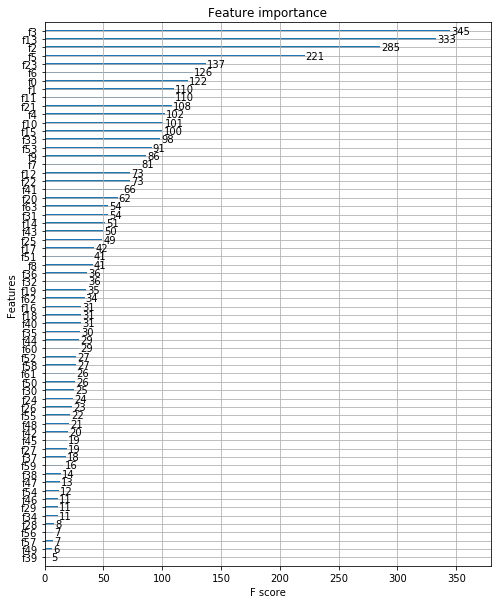

In [38]:
plot_features(model, (8,10))

In [46]:
columns = ['shop_id', 'item_id', 'date_block_num',  'item_category_id',  'item_id_avg_item_price_lag_1',
       'item_id_sum_item_cnt_day_lag_1', 'item_id_avg_item_cnt_day_lag_1',
       'shop_id_avg_item_price_lag_1', 'shop_id_sum_item_cnt_day_lag_1',
       'shop_id_avg_item_cnt_day_lag_1',
       'item_category_id_avg_item_price_lag_1',
       'item_category_id_sum_item_cnt_day_lag_1',
       'item_category_id_avg_item_cnt_day_lag_1', 'item_cnt_day_lag_1',
       'item_id_avg_item_price_lag_2', 'item_id_sum_item_cnt_day_lag_2',
       'item_id_avg_item_cnt_day_lag_2', 'shop_id_avg_item_price_lag_2',
       'shop_id_sum_item_cnt_day_lag_2', 'shop_id_avg_item_cnt_day_lag_2',
       'item_category_id_avg_item_price_lag_2',
       'item_category_id_sum_item_cnt_day_lag_2',
       'item_category_id_avg_item_cnt_day_lag_2', 'item_cnt_day_lag_2',
       'item_id_avg_item_price_lag_3', 'item_id_sum_item_cnt_day_lag_3',
       'item_id_avg_item_cnt_day_lag_3', 'shop_id_avg_item_price_lag_3',
       'shop_id_sum_item_cnt_day_lag_3', 'shop_id_avg_item_cnt_day_lag_3',
       'item_category_id_avg_item_price_lag_3',
       'item_category_id_sum_item_cnt_day_lag_3',
       'item_category_id_avg_item_cnt_day_lag_3', 'item_cnt_day_lag_3',
       'item_id_avg_item_price_lag_4', 'item_id_sum_item_cnt_day_lag_4',
       'item_id_avg_item_cnt_day_lag_4', 'shop_id_avg_item_price_lag_4',
       'shop_id_sum_item_cnt_day_lag_4', 'shop_id_avg_item_cnt_day_lag_4',
       'item_category_id_avg_item_price_lag_4',
       'item_category_id_sum_item_cnt_day_lag_4',
       'item_category_id_avg_item_cnt_day_lag_4', 'item_cnt_day_lag_4',
       'item_id_avg_item_price_lag_5', 'item_id_sum_item_cnt_day_lag_5',
       'item_id_avg_item_cnt_day_lag_5', 'shop_id_avg_item_price_lag_5',
       'shop_id_sum_item_cnt_day_lag_5', 'shop_id_avg_item_cnt_day_lag_5',
       'item_category_id_avg_item_price_lag_5',
       'item_category_id_sum_item_cnt_day_lag_5',
       'item_category_id_avg_item_cnt_day_lag_5', 'item_cnt_day_lag_5',
       'item_id_avg_item_price_lag_12', 'item_id_sum_item_cnt_day_lag_12',
       'item_id_avg_item_cnt_day_lag_12', 'shop_id_avg_item_price_lag_12',
       'shop_id_sum_item_cnt_day_lag_12', 'shop_id_avg_item_cnt_day_lag_12',
       'item_category_id_avg_item_price_lag_12',
       'item_category_id_sum_item_cnt_day_lag_12',
       'item_category_id_avg_item_cnt_day_lag_12', 'item_cnt_day_lag_12']


In [48]:
feature_importances = pd.DataFrame({'col': columns,'imp':model.feature_importances_})

In [57]:
feature_importances = feature_importances.sort_values(by='imp',ascending=False)

In [58]:
import plotly_express as px

In [59]:
px.bar(feature_importances,x='col',y='imp')